In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, fetch_olivetti_faces
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, Ridge, LogisticRegression
from sklearn.model_selection import train_test_split

PARTIE 1 : SELECTION DE CARACTERISTIQUES 

In [4]:
data = load_breast_cancer()
X_cancer = data.data
y_cancer = data.target
feature_names = data.feature_names

print(f"{X_cancer.shape[0]} échantillons, {X_cancer.shape[1]} caractéristiques")


569 échantillons, 30 caractéristiques


In [5]:
scaler = StandardScaler()
X_cancer_scaled = scaler.fit_transform(X_cancer)

 Comparaison Ridge vs Lasso

c:\Users\HP\Desktop\HAFED\M2\S3\Optimisation\TP4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\HP\Desktop\HAFED\M2\S3\Optimisation\TP4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\HP\Desktop\HAFED\M2\S3\Optimisation\TP4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values:

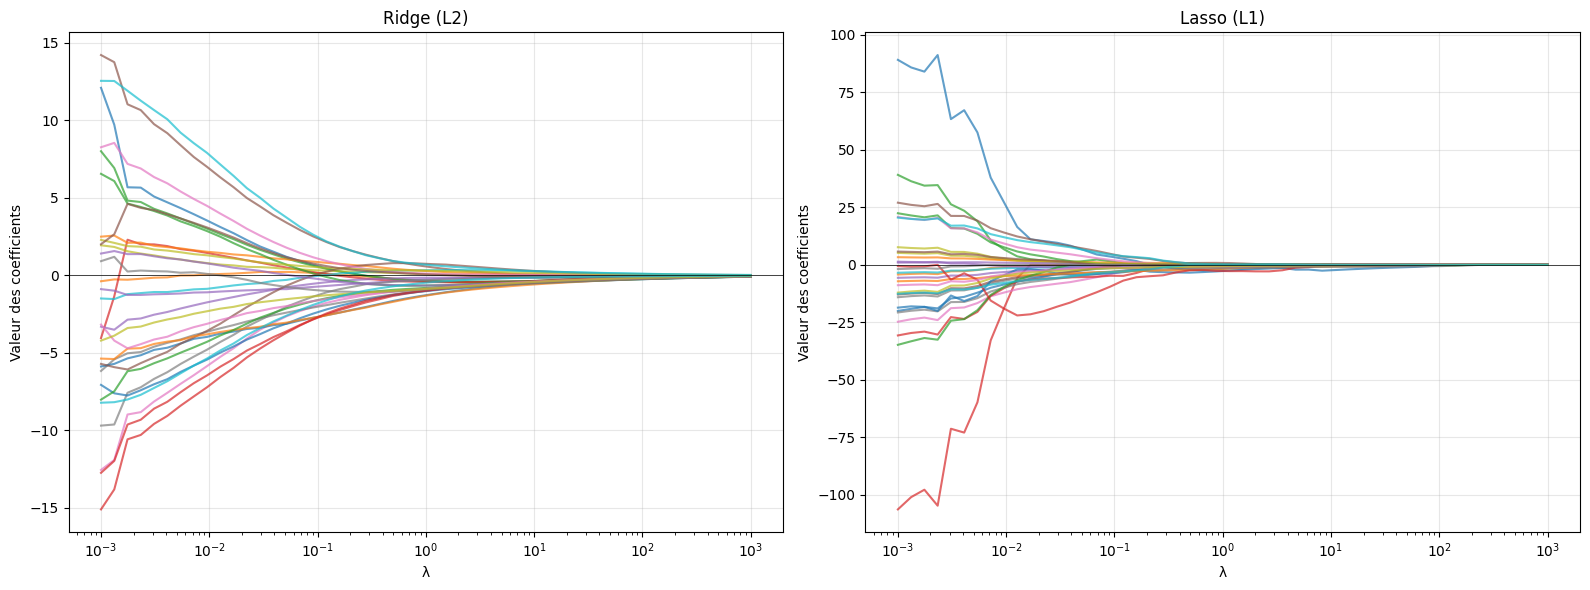

In [9]:
C_values = np.logspace(-3, 3, 50)  # C = 1/λ en scikit-learn
ridge_coefs = []
lasso_coefs = []

for C in C_values:
    # Ridge (L2)
    ridge = LogisticRegression(penalty='l2', C=C, solver='lbfgs', max_iter=10000)
    ridge.fit(X_cancer_scaled, y_cancer)
    ridge_coefs.append(ridge.coef_[0])
    
    # Lasso (L1)
    lasso = LogisticRegression(penalty='l1', C=C, solver='liblinear', max_iter=10000)
    lasso.fit(X_cancer_scaled, y_cancer)
    lasso_coefs.append(lasso.coef_[0])

ridge_coefs = np.array(ridge_coefs)
lasso_coefs = np.array(lasso_coefs)

# Graphique comparatif
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Ridge
axes[0].semilogx(1/C_values, ridge_coefs, linewidth=1.5, alpha=0.7)
axes[0].set_xlabel('λ')
axes[0].set_ylabel('Valeur des coefficients')
axes[0].set_title('Ridge (L2)')
axes[0].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[0].grid(True, alpha=0.3)

# Lasso
axes[1].semilogx(1/C_values, lasso_coefs, linewidth=1.5, alpha=0.7)
axes[1].set_xlabel('λ')
axes[1].set_ylabel('Valeur des coefficients')
axes[1].set_title('Lasso (L1)')
axes[1].axhline(y=0, color='k', linestyle='-', linewidth=0.5)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('ridge_vs_lasso_cancer.png')

Analyse pour λ = 0.5 (C = 2.0)


In [12]:
lasso_lambda05 = LogisticRegression(penalty='l1', C=2.0, solver='liblinear', max_iter=10000)
lasso_lambda05.fit(X_cancer_scaled, y_cancer)
coefs_lambda05 = lasso_lambda05.coef_[0]

n_eliminated = np.sum(np.abs(coefs_lambda05) < 1e-6)
print(f"Pour λ = 0.5 (C = 2.0):")
print(f"Nombre de variables éliminées: {n_eliminated}/{len(coefs_lambda05)}")
print(f"Nombre de variables conservées: {len(coefs_lambda05) - n_eliminated}")

# Top 3 variables les plus prédictives
top3_indices = np.argsort(np.abs(coefs_lambda05))[-3:][::-1]
print(f"Top 3 variables les plus prédictives:")
for i, idx in enumerate(top3_indices):
    print(f"   {i+1} - {feature_names[idx]}: coefficient = {coefs_lambda05[idx]:.4f}")

Pour λ = 0.5 (C = 2.0):
Nombre de variables éliminées: 12/30
Nombre de variables conservées: 18
Top 3 variables les plus prédictives:
   1 - radius error: coefficient = -3.3752
   2 - worst area: coefficient = -2.6068
   3 - worst texture: coefficient = -2.1926


c:\Users\HP\Desktop\HAFED\M2\S3\Optimisation\TP4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
c:\Users\HP\Desktop\HAFED\M2\S3\Optimisation\TP4\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1160: UserWarning: Inconsistent values: penalty=l1 with l1_ratio=0.0. penalty is deprecated. Please use l1_ratio only.
  warnings.warn(


PARTIE 2 : Debruitage par ISTA

In [11]:
faces = fetch_olivetti_faces()
image_original = faces.images[0]  # Première image

print(f"Image chargée: {image_original.shape}")


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\HP\scikit_learn_data
Image chargée: (64, 64)


Ajout du bruit

In [118]:
np.random.seed(42)
bruit = 0.1 * np.random.normal(size=image_original.shape)
image_bruit = image_original + bruit
image_bruit = np.clip(image_bruit, 0, 1) # S'assurer que les valeurs restent entre 0 et 1
print(f"Image bruitée créée: {image_bruit.shape}")

Image bruitée créée: (64, 64)


In [119]:
#fonction de seuillage doux
def soft_thresholding(v, gamma):
    return np.sign(v) * np.maximum(0, np.abs(v) - gamma)

Debruitage ISTA

In [120]:
def ista_debruitage(y_bruit, lambda_reg, max_iter=500, tol=1e-6):
    w = y_bruit.copy()
    L = 1   #Cte de Lipschitz 
    step_size = 1.0 / L
    
    objectives = []
    
    for i in range(max_iter):
        #fonction objectif
        obj = 0.5 * np.sum((w - y_bruit)**2) + lambda_reg * np.sum(np.abs(w))
        objectives.append(obj)
        
        #gradient de la partie lisse:
        gradient = w - y_bruit
        
        #pas du gradient
        w_temp = w - step_size * gradient
        
        # Pas proximal
        w_new = soft_thresholding(w_temp, lambda_reg * step_size)
        
        w = w_new
    
    return w, np.array(objectives)

Visualisation des resultats

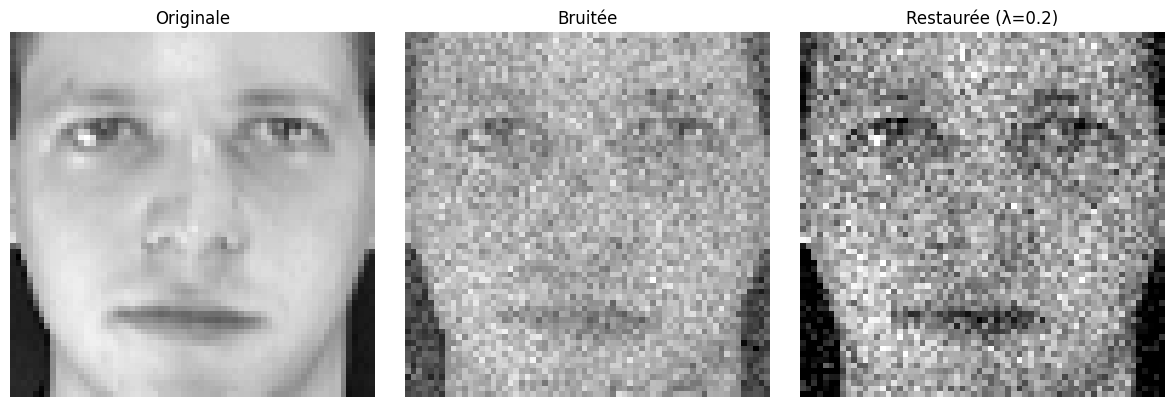

In [122]:
lambda_debruitage = 0.2
image_debruitee_ista, obj_ista = ista_debruitage(image_bruit, lambda_debruitage)

# 4. Affichage (Etape 3 de l'exercice)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(w_true.reshape(64, 64), cmap='gray')
plt.title("Originale")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(y_bruit.reshape(64, 64), cmap='gray')
plt.title("Bruitée")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(image_debruitee_ista.reshape(64, 64), cmap='gray')
plt.title(f"Restaurée (λ={lambda_debruitage})")
plt.axis('off')

plt.tight_layout()
plt.show()

Debruitage FISTA

In [116]:
def fista_debruitage(y_bruit, lambda_reg, max_iter=500, tol=1e-6):

    w = y_bruit.copy()
    z = y_bruit.copy()  # Variable intermediaire pour l'acceleration
    t = 1           # Parametre de momentum
    
    L = 1
    step_size = 1.0 / L
    
    objectives = []
    
    for i in range(max_iter):
        w_old = w.copy()
        
        #calcul de la fonction objectif sur le point actuel w
        obj = 0.5 * np.sum((w - y_bruit)**2) + lambda_reg * np.sum(np.abs(w))
        objectives.append(obj)
        
        #descente de grad sur z (variable acceleree))
        gradient = z - y_bruit
        w_temp = z - step_size * gradient
        
        #seuillage doux
        w = soft_thresholding(w_temp, lambda_reg * step_size)
            
        #maj du momentum
        t_next = (1 + np.sqrt(1 + 4 * t**2)) / 2
        z = w + ((t - 1) / t_next) * (w - w_old)
        t = t_next
        
    return w, np.array(objectives)

image_debruitee_fista, obj_fista = ista_debruitage(y_bruit, lambda_debruitage)

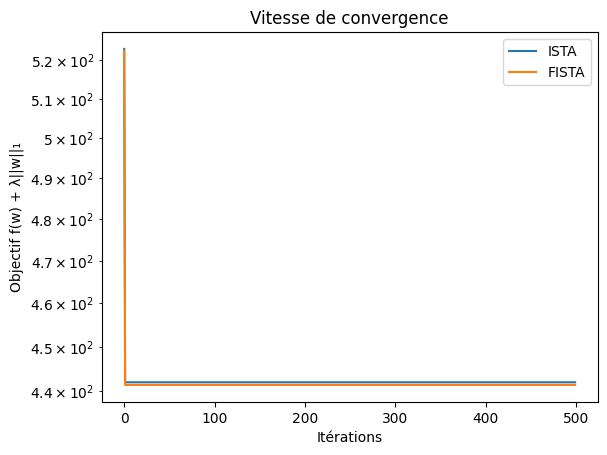

In [117]:
plt.figure()
plt.plot(obj_ista, label='ISTA')
plt.plot(obj_fista, label='FISTA') 
plt.yscale('log')
plt.xlabel('Itérations')
plt.ylabel('Objectif f(w) + λ||w||₁')
plt.legend()
plt.title("Vitesse de convergence")
plt.show()

        Norme L1 vs L2 

La norme L1 est plus adaptée car elle favorise la parcimonie, ce qui est essentiel pour la sélection de variables ou le débruitage "intelligent" :
    
+ Géométriquement, les boules de la norme L1 sont des losanges possédant des sommets pointus sur les axes. Lors de la minimisation, la fonction de perte a de fortes chances de toucher un de ces sommets, ce qui annule exactement certaines composantes du vecteur $w$.

+ Contrairement à la norme L2 dont la dérivée diminue à mesure qu'on approche de zéro, le sous-différentiel de la norme L1 reste "fort" près de l'origine (pente de 1 ou -1). Cela "pousse" activement les petits coefficients (souvent associés au bruit) jusqu'à zéro. 
    
+ La norme L2 réduit la taille de tous les coefficients mais ne les annule quasiment jamais. La norme L1 effectue un seuillage : elle élimine les variables inutiles.

        Influence de lambda sur l'aspect visuel de l'image


+ Lorsque lambda est faible : l'image obtenue reste très proche de l'image bruitée. Le grain du bruit est toujours visible car peu de coefficients ont été mis à zéro. 

+ Lorsque lambda est fort : l'image devient très lisse. On perd les détails importants du visage (yeux, bouche, textures de peau) car ils sont confondus avec le bruit et annulés par le seuillage. Si $\lambda$ est extrême, l'image peut devenir uniformément grise ou noire.